In [64]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV 
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np
from imblearn.over_sampling import SMOTE
# Establecer semilla para reproducibilidad
np.random.seed(42)

In [ ]:
# Cargar los datos latentes generados por el VAE
# Cargar embeddings
X_latent = pd.read_csv("data/vae_embeddings_v2.csv", index_col=0)

# Cargar etiquetas
y = pd.read_csv("data/y_labels.csv", index_col=0).values.ravel()

In [205]:
X_train, X_test, y_train, y_test = train_test_split(
    X_latent, y, test_size=0.2, stratify=y, random_state=42
)

In [206]:
# definir modelo base + búsqueda de hiperparámetros
param_grid = {
    "n_estimators": [50, 100, 150, 200, 250],
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
    "subsample": [0.8, 1.0],
}

xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42
)

In [207]:
# validación cruzada
grid = GridSearchCV(xgb_model, param_grid, cv=5, scoring="roc_auc", verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


/home/jsullon/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:50:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jsullon/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:50:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jsullon/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:50:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jsullon/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:50:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jsullon/.local/lib/python3.10/site-packages/xgboost/tr

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [50, 100, 150, 200, 250],
                         'subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=1)

In [208]:
cv_results = pd.DataFrame(grid.cv_results_)
cv_results = cv_results.sort_values(by="mean_test_score", ascending=False)

# Mostrar top 5 combinaciones
print(cv_results[["params", "mean_test_score", "std_test_score"]].head())

                                                params  mean_test_score  \
180  {'learning_rate': 0.4, 'max_depth': 7, 'n_esti...         0.465042   
190  {'learning_rate': 0.4, 'max_depth': 9, 'n_esti...         0.465042   
230  {'learning_rate': 0.5, 'max_depth': 9, 'n_esti...         0.454913   
220  {'learning_rate': 0.5, 'max_depth': 7, 'n_esti...         0.454913   
182  {'learning_rate': 0.4, 'max_depth': 7, 'n_esti...         0.453038   

     std_test_score  
180        0.089422  
190        0.089422  
230        0.075667  
220        0.075667  
182        0.096946  


In [209]:
# Resultados
best_model = grid.best_estimator_
print("🧠 Mejores parámetros:", grid.best_params_)

🧠 Mejores parámetros: {'learning_rate': 0.4, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


In [210]:
# Predicción de probabilidades y ajuste de umbral óptimo
y_proba = best_model.predict_proba(X_test)[:, 1]

# Encuentra el mejor umbral basado en F1
prec, rec, thresh = precision_recall_curve(y_test, y_proba)
f1 = 2 * (prec * rec) / (prec + rec + 1e-6)
best_thresh = thresh[np.argmax(f1)]
print(f"📈 Mejor umbral por F1: {best_thresh:.2f}")

y_pred_opt = (y_proba >= best_thresh).astype(int)

📈 Mejor umbral por F1: 0.17


In [211]:
# Reportes
print("\n📋 Reporte de clasificación:")
print(classification_report(y_test, y_pred_opt))
print("🔍 AUROC (test):", roc_auc_score(y_test, y_proba))


📋 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95        73
           1       0.50      0.25      0.33         8

    accuracy                           0.90        81
   macro avg       0.71      0.61      0.64        81
weighted avg       0.88      0.90      0.89        81

🔍 AUROC (test): 0.678082191780822


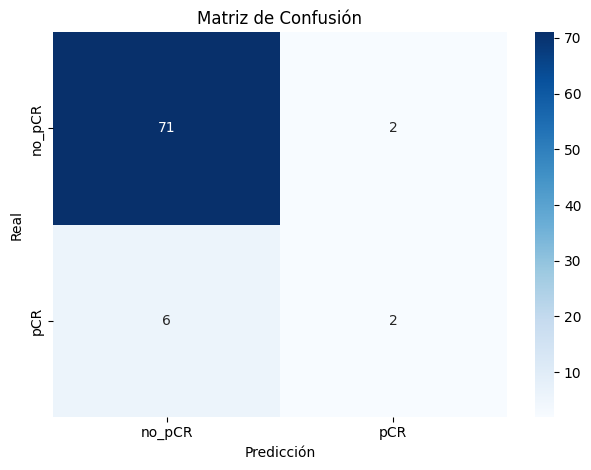

In [212]:
# Matriz de confusión
conf = confusion_matrix(y_test, y_pred_opt)
sns.heatmap(conf, annot=True, fmt="d", cmap="Blues", xticklabels=["no_pCR", "pCR"], yticklabels=["no_pCR", "pCR"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

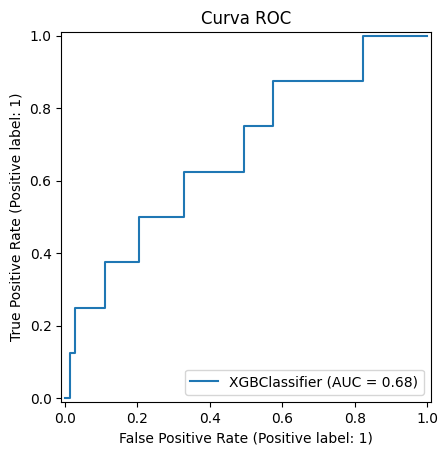

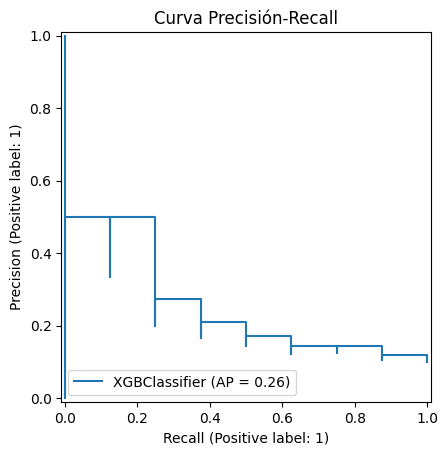

In [213]:
# Curvas ROC y PR
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("Curva ROC")
plt.show()

PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test)
plt.title("Curva Precisión-Recall")
plt.show()

In [ ]:
# Guardar modelo y umbral
joblib.dump(best_model, "models/xgboost_model_vae.joblib")
np.save("models/best_threshold.npy", best_thresh)

print("✅ Modelo y umbral guardados.")

✅ Modelo y umbral guardados.


### Con SMOTE

In [215]:
# Aplicar SMOTE al entrenamiento (solo a train)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Distribución antes de SMOTE:", str(np.bincount(y_train.astype(int))))
print("Distribución después de SMOTE:", str(np.bincount(y_train_res.astype(int))))

Distribución antes de SMOTE: [288  34]
Distribución después de SMOTE: [288 288]


In [216]:
# validación cruzada
grid = GridSearchCV(xgb_model, param_grid, cv=5, scoring="roc_auc", verbose=1, n_jobs=-1)
grid.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


/home/jsullon/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:51:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jsullon/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:51:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jsullon/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:51:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jsullon/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:51:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jsullon/.local/lib/python3.10/site-packages/xgboost/tr

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [50, 100, 150, 200, 250],
                         'subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=1)

In [217]:
# Resultados
best_model = grid.best_estimator_
print("🧠 Mejores parámetros:", grid.best_params_)

🧠 Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.8}


In [218]:
# Predicción de probabilidades y ajuste de umbral óptimo
y_proba = best_model.predict_proba(X_test)[:, 1]

# Encuentra el mejor umbral basado en F1
prec, rec, thresh = precision_recall_curve(y_test, y_proba)
f1 = 2 * (prec * rec) / (prec + rec + 1e-6)
best_thresh = thresh[np.argmax(f1)]
print(f"📈 Mejor umbral por F1: {best_thresh:.2f}")

y_pred_opt = (y_proba >= best_thresh).astype(int)

📈 Mejor umbral por F1: 0.65


In [219]:
# Reportes
print("\n📋 Reporte de clasificación:")
print(classification_report(y_test, y_pred_opt))
print("🔍 AUROC (test):", roc_auc_score(y_test, y_proba))


📋 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95        73
           1       0.50      0.25      0.33         8

    accuracy                           0.90        81
   macro avg       0.71      0.61      0.64        81
weighted avg       0.88      0.90      0.89        81

🔍 AUROC (test): 0.7328767123287672


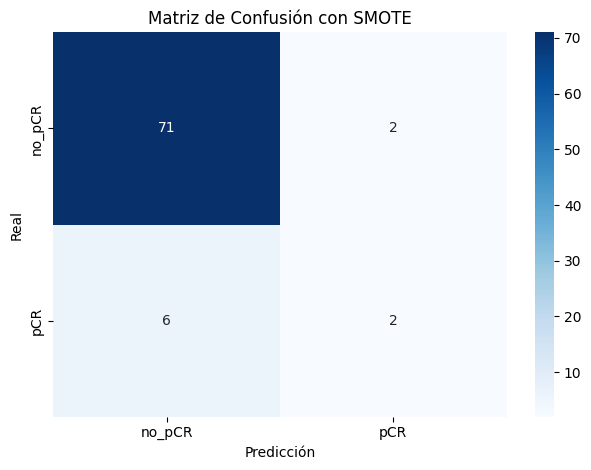

In [220]:
# Matriz de confusión
conf = confusion_matrix(y_test, y_pred_opt)
sns.heatmap(conf, annot=True, fmt="d", cmap="Blues", xticklabels=["no_pCR", "pCR"], yticklabels=["no_pCR", "pCR"])
plt.title("Matriz de Confusión con SMOTE")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import joblib

# 1. Cargar modelo y umbral
model = joblib.load("models/xgboost_model_vae.joblib")
threshold = np.load("models/best_threshold.npy")

# 2. Cargar vectores latentes 
df_latentes = pd.read_csv("data/vae_embeddings_test.csv", header=None, usecols=range(1, 51))  # No tiene nombres de columna

# 3. Cargar metadatos con IDs
df_ids = pd.read_csv("data/BRCA_sin_respuesta_final.csv")  # Debe tener columna submitter_id.samples

# 4. Asegurarse que ambos tienen el mismo número de filas
assert len(df_latentes) == len(df_ids), "¡Los archivos no tienen la misma cantidad de filas!"

# 5. Hacer predicción
X_test = df_latentes.values
y_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= threshold).astype(int)

# 6. Armar DataFrame de resultados
df_resultado = pd.DataFrame({
    "submitter_id": df_ids["submitter_id.samples"],
    "predicted_class": y_pred
})

# 7. Guardar a Excel
df_resultado.to_csv("predictions/predicciones_test_xgboost.csv", index=False)

print("✅ Archivo 'predictions/predicciones_test_xgboost.csv' generado correctamente.")


✅ Archivo 'data/predicciones_test.csv' generado correctamente.
